In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [8]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_calc', 'X_train.npy'))
    labels = np.load(os.path.join('Data_calc', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_calc', 'X_test.npy'))
    labels = np.load(os.path.join('Data_calc', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [3]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1528 	 Test size: 344
Image size: 256x256


In [4]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,

In [5]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1528, 256, 256, 1)

In [7]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

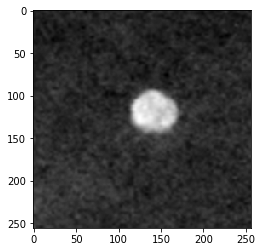

Label: [1. 0.]
[[[121.015625   121.015625   121.015625  ]
  [120.58984375 120.58984375 120.58984375]
  [120.0078125  120.0078125  120.0078125 ]
  ...
  [ 59.14453125  59.14453125  59.14453125]
  [ 55.98046875  55.98046875  55.98046875]
  [ 53.734375    53.734375    53.734375  ]]

 [[121.39453125 121.39453125 121.39453125]
  [120.53515625 120.53515625 120.53515625]
  [119.35546875 119.35546875 119.35546875]
  ...
  [ 58.4296875   58.4296875   58.4296875 ]
  [ 56.27734375  56.27734375  56.27734375]
  [ 54.8046875   54.8046875   54.8046875 ]]

 [[122.01171875 122.01171875 122.01171875]
  [120.51171875 120.51171875 120.51171875]
  [118.4453125  118.4453125  118.4453125 ]
  ...
  [ 57.35546875  57.35546875  57.35546875]
  [ 56.76171875  56.76171875  56.76171875]
  [ 56.47265625  56.47265625  56.47265625]]

 ...

 [[134.48828125 134.48828125 134.48828125]
  [135.69921875 135.69921875 135.69921875]
  [137.5546875  137.5546875  137.5546875 ]
  ...
  [115.1328125  115.1328125  115.1328125 ]
  [

In [11]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

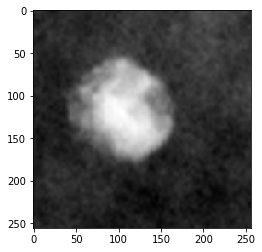

Label: [1. 0.]
[[[121.015625   121.015625   121.015625  ]
  [120.58984375 120.58984375 120.58984375]
  [120.0078125  120.0078125  120.0078125 ]
  ...
  [ 59.14453125  59.14453125  59.14453125]
  [ 55.98046875  55.98046875  55.98046875]
  [ 53.734375    53.734375    53.734375  ]]

 [[121.39453125 121.39453125 121.39453125]
  [120.53515625 120.53515625 120.53515625]
  [119.35546875 119.35546875 119.35546875]
  ...
  [ 58.4296875   58.4296875   58.4296875 ]
  [ 56.27734375  56.27734375  56.27734375]
  [ 54.8046875   54.8046875   54.8046875 ]]

 [[122.01171875 122.01171875 122.01171875]
  [120.51171875 120.51171875 120.51171875]
  [118.4453125  118.4453125  118.4453125 ]
  ...
  [ 57.35546875  57.35546875  57.35546875]
  [ 56.76171875  56.76171875  56.76171875]
  [ 56.47265625  56.47265625  56.47265625]]

 ...

 [[134.48828125 134.48828125 134.48828125]
  [135.69921875 135.69921875 135.69921875]
  [137.5546875  137.5546875  137.5546875 ]
  ...
  [115.1328125  115.1328125  115.1328125 ]
  [

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

vgg16_fe_drop_temp.summary()

In [14]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128, output = 2)

In [15]:
vgg16_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

In [15]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [24]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.5979 - accuracy: 0.5341
Epoch 00001: val_loss improved from inf to 0.97568, saving model to vgg16_fe_drop_128_4cl_best.h5
5/5 [==============================] - 18s 4s/step - loss: 1.4892 - accuracy: 0.5334 - val_loss: 0.9757 - val_accuracy: 0.5639
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2796 - accuracy: 0.5780
Epoch 00002: val_loss improved from 0.97568 to 0.74184, saving model to vgg16_fe_drop_128_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 1.3561 - accuracy: 0.5575 - val_loss: 0.7418 - val_accuracy: 0.6230
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1100 - accuracy: 0.6440
Epoch 00003: val_loss did not improve from 0.74184
5/5 [==============================] - 11s 2s/step

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6853 - accuracy: 0.6725
Epoch 00028: val_loss did not improve from 0.58414
5/5 [==============================] - 11s 2s/step - loss: 0.7195 - accuracy: 0.6569 - val_loss: 0.6122 - val_accuracy: 0.7016
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7980 - accuracy: 0.6505
Epoch 00029: val_loss did not improve from 0.58414
5/5 [==============================] - 10s 2s/step - loss: 0.8024 - accuracy: 0.6501 - val_loss: 0.6110 - val_accuracy: 0.6721
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6466 - accuracy: 0.6758
Epoch 00030: val_loss did not improve from 0.58414
5/5 [==============================] - 10s 2s/step - loss: 0.6473 - accuracy: 0.6875 - val_loss: 0.6648 - val_accuracy: 0.6492
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6057 - accuracy: 0.7109
Epoch 00031: val_loss did not improve from 0.58414
5/5 [==============================] - 

Epoch 57/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6335 - accuracy: 0.6769
Epoch 00057: val_loss did not improve from 0.54193
5/5 [==============================] - 10s 2s/step - loss: 0.6596 - accuracy: 0.6758 - val_loss: 0.5576 - val_accuracy: 0.6721
Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5340 - accuracy: 0.7121
Epoch 00058: val_loss did not improve from 0.54193
5/5 [==============================] - 10s 2s/step - loss: 0.5478 - accuracy: 0.7050 - val_loss: 0.5609 - val_accuracy: 0.6525
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6320 - accuracy: 0.6527
Epoch 00059: val_loss improved from 0.54193 to 0.53784, saving model to vgg16_fe_drop_128_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.6021 - accuracy: 0.6827 - val_loss: 0.5378 - val_accuracy: 0.6984
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6335 - accuracy: 0.6758
Epoch 00060: val_loss did not improve f

Epoch 116/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5488 - accuracy: 0.6836
Epoch 00116: val_loss did not improve from 0.51573
5/5 [==============================] - 11s 2s/step - loss: 0.5710 - accuracy: 0.6687 - val_loss: 0.5402 - val_accuracy: 0.6951
Epoch 117/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5867 - accuracy: 0.7070
Epoch 00117: val_loss did not improve from 0.51573
5/5 [==============================] - 11s 2s/step - loss: 0.5842 - accuracy: 0.7078 - val_loss: 0.5409 - val_accuracy: 0.7213
Epoch 118/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5618 - accuracy: 0.7011
Epoch 00118: val_loss did not improve from 0.51573
5/5 [==============================] - 11s 2s/step - loss: 0.5753 - accuracy: 0.6964 - val_loss: 0.5232 - val_accuracy: 0.7148
Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5544 - accuracy: 0.7209
Epoch 00119: val_loss did not improve from 0.51573
5/5 [==============================

In [25]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [27]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [28]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 126
Epoch [opt]: 96
Valid accuracy [end]: 0.7213
Valid accuracy [opt]: 0.7049
Test accuracy [end]:  0.7093
Test accuracy [opt]:  0.6890
Valid loss [end]: 0.5488
Valid loss [opt]: 0.5157
Test loss [end]:  0.5592
Test loss [opt]:  0.5798


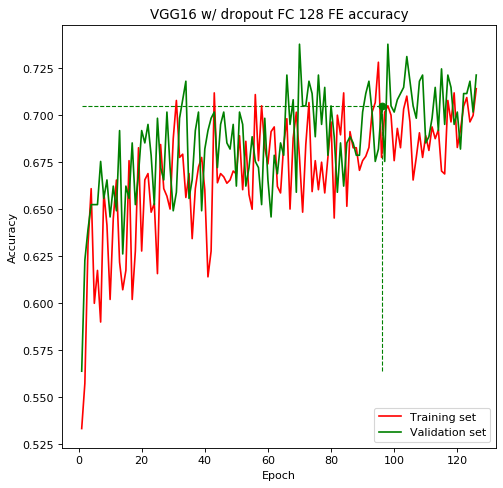

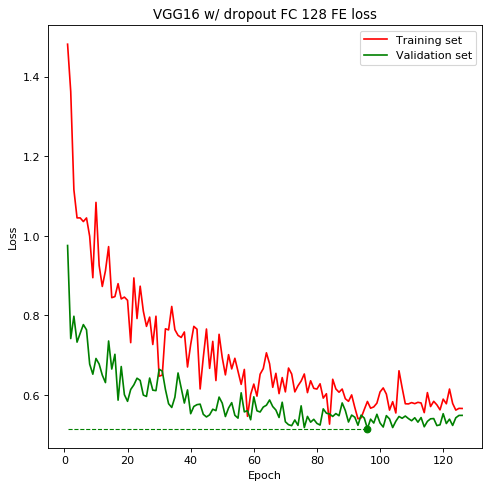

In [29]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [24]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256, output=2)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 3 steps
Epoch 1/150
 9/10 [==========================>...] - ETA: 1s - loss: 1.6675 - accuracy: 0.5242
Epoch 00001: val_loss improved from inf to 1.22850, saving model to vgg16_fe_drop_256_4cl_best.h5
10/10 [==============================] - 17s 2s/step - loss: 1.6707 - accuracy: 0.5266 - val_loss: 1.2285 - val_accuracy: 0.5148
Epoch 2/150
 9/10 [==========================>...] - ETA: 1s - loss: 1.5454 - accuracy: 0.5041
Epoch 00002: val_loss improved from 1.22850 to 1.09535, saving model to vgg16_fe_drop_256_4cl_best.h5
10/10 [==============================] - 16s 2s/step - loss: 1.5512 - accuracy: 0.5070 - val_loss: 1.0953 - val_accuracy: 0.5115
Epoch 3/150
 9/10 [==========================>...] - ETA: 1s - loss: 1.4468 - accuracy: 0.5461
Epoch 00003: val_loss improved from 1.09535 to 1.02361, saving model to vgg16_fe_drop_256_4cl_best.h5
10/10 [==============================] - 16s 2s/step - loss: 1.4

Epoch 29/150
 9/10 [==========================>...] - ETA: 1s - loss: 1.0364 - accuracy: 0.6466
Epoch 00029: val_loss did not improve from 0.68991
10/10 [==============================] - 16s 2s/step - loss: 1.0273 - accuracy: 0.6468 - val_loss: 0.7479 - val_accuracy: 0.6820
Epoch 30/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.9633 - accuracy: 0.6301
Epoch 00030: val_loss did not improve from 0.68991
10/10 [==============================] - 16s 2s/step - loss: 0.9890 - accuracy: 0.6321 - val_loss: 0.7677 - val_accuracy: 0.6689
Epoch 31/150
 9/10 [==========================>...] - ETA: 1s - loss: 1.0372 - accuracy: 0.6192
Epoch 00031: val_loss did not improve from 0.68991
10/10 [==============================] - 16s 2s/step - loss: 1.0398 - accuracy: 0.6271 - val_loss: 0.7051 - val_accuracy: 0.6754
Epoch 32/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.9824 - accuracy: 0.6347
Epoch 00032: val_loss did not improve from 0.68991
10/10 [==================

Epoch 58/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.9194 - accuracy: 0.6584
Epoch 00058: val_loss did not improve from 0.55471
10/10 [==============================] - 16s 2s/step - loss: 0.9503 - accuracy: 0.6525 - val_loss: 0.6560 - val_accuracy: 0.7180
Epoch 59/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.8800 - accuracy: 0.6612
Epoch 00059: val_loss did not improve from 0.55471
10/10 [==============================] - 16s 2s/step - loss: 0.8975 - accuracy: 0.6525 - val_loss: 0.7189 - val_accuracy: 0.6787
Epoch 60/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.9475 - accuracy: 0.6457
Epoch 00060: val_loss did not improve from 0.55471
10/10 [==============================] - 16s 2s/step - loss: 0.9427 - accuracy: 0.6525 - val_loss: 0.7055 - val_accuracy: 0.6721
Epoch 61/150
 9/10 [==========================>...] - ETA: 1s - loss: 0.8625 - accuracy: 0.6721
Epoch 00061: val_loss did not improve from 0.55471
10/10 [==================

In [26]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [27]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 82
Epoch [opt]: 52
Valid accuracy [end]: 0.6787
Valid accuracy [opt]: 0.6820
Test accuracy [end]:  0.6599
Test accuracy [opt]:  0.6686
Valid loss [end]: 0.6551
Valid loss [opt]: 0.5547
Test loss [end]:  0.8214
Test loss [opt]:  0.8816


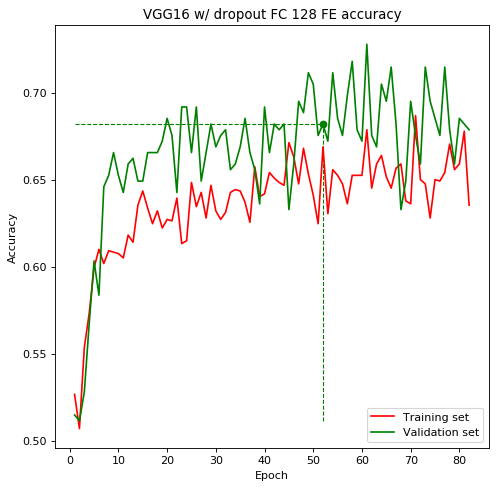

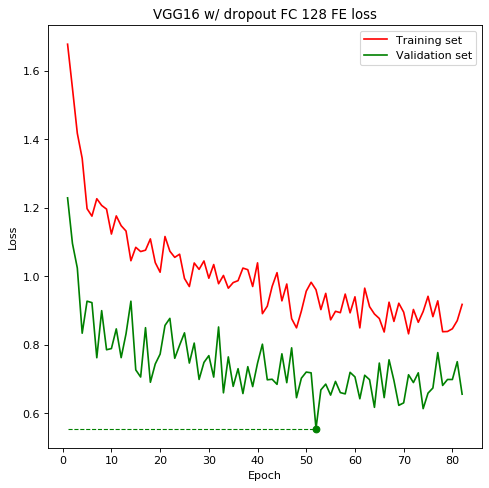

In [28]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [14]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

In [30]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 36,046,722
Non-trainable params: 12,354,880
___________________________________

In [31]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [32]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3240 - accuracy: 0.6445
Epoch 00001: val_loss improved from inf to 0.53370, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1760 - accuracy: 0.6453 - val_loss: 0.5337 - val_accuracy: 0.6820
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6337 - accuracy: 0.6791
Epoch 00002: val_loss did not improve from 0.53370
5/5 [==============================] - 10s 2s/step - loss: 0.6321 - accuracy: 0.6844 - val_loss: 0.5852 - val_accuracy: 0.6852
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6273 - accuracy: 0.6816
Epoch 00003: val_loss did not improve from 0.53370
5/5 [==============================] - 10s 2s/step - loss: 0.6282 - accuracy: 0.6844 - val_loss: 0.5341 - val_accuracy: 0.7049
Epoch 4/300
4/5 [=======================>......] - E

5/5 [==============================] - 11s 2s/step - loss: 0.4947 - accuracy: 0.7094 - val_loss: 0.5072 - val_accuracy: 0.7279
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5307 - accuracy: 0.6923
Epoch 00030: val_loss did not improve from 0.50719
5/5 [==============================] - 10s 2s/step - loss: 0.5336 - accuracy: 0.6878 - val_loss: 0.5507 - val_accuracy: 0.6918
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5142 - accuracy: 0.7227
Epoch 00031: val_loss did not improve from 0.50719
5/5 [==============================] - 10s 2s/step - loss: 0.5396 - accuracy: 0.7047 - val_loss: 0.5832 - val_accuracy: 0.7246
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5109 - accuracy: 0.7441
Epoch 00032: val_loss did not improve from 0.50719
5/5 [==============================] - 10s 2s/step - loss: 0.5093 - accuracy: 0.7422 - val_loss: 0.5709 - val_accuracy: 0.6984
Epoch 33/300
4/5 [=======================>......] - ETA: 

Epoch 00059: early stopping


In [33]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [34]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 59
Epoch [opt]: 29
Valid accuracy [end]: 0.6984
Valid accuracy [opt]: 0.7279
Test accuracy [end]:  0.7267
Test accuracy [opt]:  0.7064
Valid loss [end]: 0.6451
Valid loss [opt]: 0.5072
Test loss [end]:  0.6158
Test loss [opt]:  0.5220


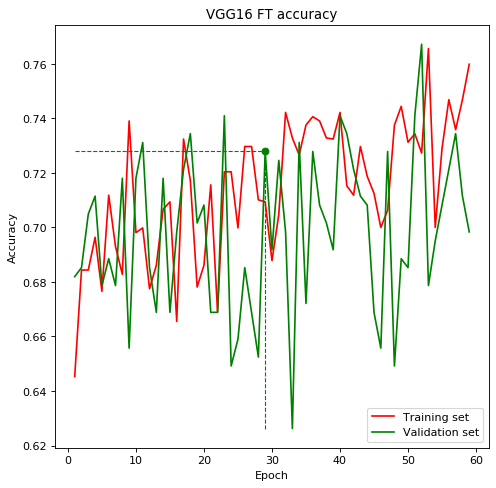

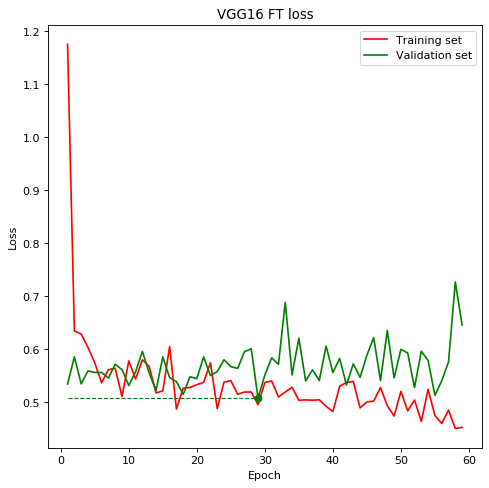

In [35]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [36]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 38,406,530
Non-trainable params: 9,995,072
____________________________________

In [37]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [38]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5042 - accuracy: 0.7168
Epoch 00001: val_loss improved from inf to 0.56690, saving model to vgg16_ft_2layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.4909 - accuracy: 0.7406 - val_loss: 0.5669 - val_accuracy: 0.7082
Epoch 2/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5238 - accuracy: 0.7077
Epoch 00002: val_loss improved from 0.56690 to 0.52021, saving model to vgg16_ft_2layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5201 - accuracy: 0.7187 - val_loss: 0.5202 - val_accuracy: 0.7344
Epoch 3/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4948 - accuracy: 0.7285
Epoch 00003: val_loss did not improve from 0.52021
5/5 [==============================] - 11s 2s/step - loss: 0.4952 - accuracy: 0.7203 - val_loss: 0.5547 - val_accuracy: 0.6787
Epo

Epoch 30/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4831 - accuracy: 0.7480
Epoch 00030: val_loss did not improve from 0.49803
5/5 [==============================] - 10s 2s/step - loss: 0.4768 - accuracy: 0.7500 - val_loss: 0.5438 - val_accuracy: 0.7016
Epoch 31/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5051 - accuracy: 0.6945
Epoch 00031: val_loss did not improve from 0.49803
5/5 [==============================] - 11s 2s/step - loss: 0.5182 - accuracy: 0.6913 - val_loss: 0.5281 - val_accuracy: 0.6984
Epoch 32/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5048 - accuracy: 0.7285
Epoch 00032: val_loss improved from 0.49803 to 0.49292, saving model to vgg16_ft_2layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5158 - accuracy: 0.7188 - val_loss: 0.4929 - val_accuracy: 0.7541
Epoch 33/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5165 - accuracy: 0.7090
Epoch 00033: val_loss did not improve fro

Epoch 60/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4622 - accuracy: 0.7559
Epoch 00060: val_loss did not improve from 0.49292
5/5 [==============================] - 10s 2s/step - loss: 0.4616 - accuracy: 0.7530 - val_loss: 0.5383 - val_accuracy: 0.7213
Epoch 61/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4758 - accuracy: 0.7656
Epoch 00061: val_loss did not improve from 0.49292
5/5 [==============================] - 11s 2s/step - loss: 0.4689 - accuracy: 0.7719 - val_loss: 0.5294 - val_accuracy: 0.7049
Epoch 62/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4615 - accuracy: 0.7560
Epoch 00062: val_loss did not improve from 0.49292
5/5 [==============================] - 10s 2s/step - loss: 0.4626 - accuracy: 0.7547 - val_loss: 0.5597 - val_accuracy: 0.7115
Epoch 00062: early stopping


In [24]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 32
Epoch [opt]: 2
Valid accuracy [end]: 0.6328
Valid accuracy [opt]: 0.7180
Test accuracy [end]:  0.7209
Test accuracy [opt]:  0.7151
Valid loss [end]: 0.6179
Valid loss [opt]: 0.5496
Test loss [end]:  0.4953
Test loss [opt]:  0.5181


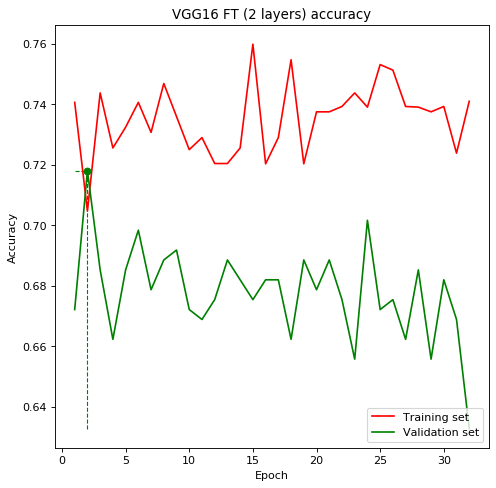

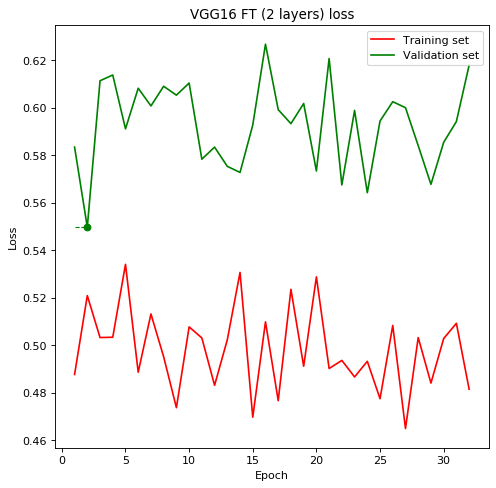

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 40,766,338
Non-trainable params: 7,635,264
____________________________________

In [28]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [29]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
1/5 [=====>........................] - ETA: 54sWARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[128,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/vgg16/block1_conv2/Conv2D (defined at <ipython-input-29-de23bd7faa7a>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_17535]

Function call stack:
distributed_function


In [ ]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();


In [103]:
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
eye_casecade = cv2.CascadeClassifier('haarcascade_eye.xml')

fp='C:/Users/dahyun/Desktop/1.jpg'

img = cv2.imread(fp,cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [104]:
faces = face_cascade.detectMultiScale(gray, 1.3,5)
faces

()

In [105]:
for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_casecade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh),(0,255,0),2)

cv2.imshow('Image view', img)
cv2.waitKey(0)
cv2.destroyAllWindows()